In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
# DnCNN Model Definition, Data Prep, and Training Loop for Colab
"""
Define, inspect, prepare data, and train the DnCNN denoiser interactively in a Colab notebook.
Includes utilities for computing dataset statistics, loading from ZIPs, and a basic train/val loop
that tracks both MSE loss and SSIM.
"""
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
import zipfile, io
from PIL import Image
from tqdm import tqdm
import math
from pathlib import Path
import torch.nn.functional as F
from pytorch_msssim import ssim
import os

In [ ]:
# ---------------------------------------------
# 1. DnCNN Definition and Inspection
# ---------------------------------------------
class DnCNN(nn.Module):
    """
    Denoising CNN that predicts noise and subtracts it from input.
    """
    def __init__(self, in_channels=1, num_layers=17, num_features=64):
        super().__init__()
        layers = []
        # Initial conv + ReLU
        layers.append(nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))
        # Hidden blocks: conv + batchnorm + ReLU
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(num_features))
            layers.append(nn.ReLU(inplace=True))
        # Final conv predicts noise
        layers.append(nn.Conv2d(num_features, in_channels, kernel_size=3, padding=1, bias=False))
        # Use attribute 'model' for consistency
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.model(x)
        return x - noise


In [ ]:
def inspect_dncnn(in_channels=1, num_layers=17, img_size=(256, 256), batch_size=1):
    """
    Print model summary and layer shapes on a dummy input.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DnCNN(in_channels, num_layers).to(device)
    print(f"Building DnCNN: layers={num_layers}, features={model.model[0].out_channels}, in_channels={in_channels}")
    summary(model, (in_channels, *img_size), batch_size=batch_size, device=device.type)

    # Layer-by-layer shape tracing
    x = torch.zeros(batch_size, in_channels, *img_size, device=device)
    print("\nLayer-by-layer shapes:")
    out = x
    for idx, layer in enumerate(model.model, 1):
        out = layer(out)
        print(f"Layer {idx:02d}: {layer.__class__.__name__} -> {tuple(out.shape)}")

In [ ]:
def compute_mean_std(zip_path):
    zf = zipfile.ZipFile(zip_path,'r')
    imgs = [f for f in zf.namelist() if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))]
    sum_m, sum_v, cnt = 0.0,0.0,0
    for f in tqdm(imgs, desc=f"Stats {zip_path}"):
        with zf.open(f) as fp:
            img = Image.open(io.BytesIO(fp.read())).convert('L')
        t = transforms.ToTensor()(img)
        sum_m += t.mean().item(); sum_v += t.var(unbiased=False).item(); cnt+=1
    mean = sum_m/cnt; std = math.sqrt(sum_v/cnt)
    return mean, std

def compute_all_stats(zips):
    stats={}
    for p in zips:
        m,s=compute_mean_std(p); print(f"{p}: mean={m:.4f}, std={s:.4f}"); stats[p]=(m,s)
    return stats

In [ ]:
stats = compute_all_stats([
    '/content/drive/MyDrive/IA2/dataset/train_clean.zip',
    '/content/drive/MyDrive/IA2/dataset/val_clean.zip',
    '/content/drive/MyDrive/IA2/dataset/test_clean.zip'
])

Stats /content/drive/MyDrive/IA2/dataset/train_clean.zip: 100%|██████████| 6000/6000 [00:09<00:00, 639.42it/s]


/content/drive/MyDrive/IA2/dataset/train_clean.zip: mean=0.1781, std=0.1976


Stats /content/drive/MyDrive/IA2/dataset/val_clean.zip: 100%|██████████| 2000/2000 [00:04<00:00, 477.05it/s]


/content/drive/MyDrive/IA2/dataset/val_clean.zip: mean=0.1799, std=0.1984


Stats /content/drive/MyDrive/IA2/dataset/test_clean.zip: 100%|██████████| 2000/2000 [00:03<00:00, 596.57it/s]

/content/drive/MyDrive/IA2/dataset/test_clean.zip: mean=0.1779, std=0.1971


In [ ]:
inspect_dncnn(in_channels=1, num_layers=17, img_size=(256,256), batch_size=1)

Building DnCNN: layers=17, features=64, in_channels=1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]             640
              ReLU-2          [1, 64, 256, 256]               0
            Conv2d-3          [1, 64, 256, 256]          36,864
       BatchNorm2d-4          [1, 64, 256, 256]             128
              ReLU-5          [1, 64, 256, 256]               0
            Conv2d-6          [1, 64, 256, 256]          36,864
       BatchNorm2d-7          [1, 64, 256, 256]             128
              ReLU-8          [1, 64, 256, 256]               0
            Conv2d-9          [1, 64, 256, 256]          36,864
      BatchNorm2d-10          [1, 64, 256, 256]             128
             ReLU-11          [1, 64, 256, 256]               0
           Conv2d-12          [1, 64, 256, 256]          36,864
      BatchNorm2d-13          [1, 64, 256, 256]  

In [ ]:
# ---------------------------------------------
# 3. Transforms with Resize
# ---------------------------------------------
# Use stats from train_clean.zip
mean, std = [0.1781], [0.1976]
# Target resolution
target_size = (256, 256)

train_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
import zipfile, io
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
# ---------------------------------------------
# 4. ZIP Dataset Loader
# ---------------------------------------------
class PairedZipDataset(torch.utils.data.Dataset):
    """
    Reads paired clean/noisy images directly from ZIP archives.
    Lazily opens ZIP files per worker and matches on basenames in 'clean/' and 'noisy/' folders.
    """
    def __init__(self, clean_zip, noisy_zip, transform=None):
        self.clean_zip_path = clean_zip
        self.noisy_zip_path = noisy_zip
        # List all clean/ filenames once
        with zipfile.ZipFile(self.clean_zip_path) as zc:
            self.fnames = sorted(
                Path(f).name
                for f in zc.namelist()
                if f.startswith("clean/") and f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))
            )
        self.transform = transform or (lambda x: x)
        # placeholders for per-worker zipfile handles
        self.zc = None
        self.zn = None

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        # lazily open archives per worker
        if self.zc is None:
            self.zc = zipfile.ZipFile(self.clean_zip_path)
        if self.zn is None:
            self.zn = zipfile.ZipFile(self.noisy_zip_path)

        fname = self.fnames[idx]
        clean_path = f"clean/{fname}"
        noisy_path = f"noisy_15_awgn/{fname}"

        # Read and decode images
        data_c = self.zc.read(clean_path)
        data_n = self.zn.read(noisy_path)
        img_c = Image.open(io.BytesIO(data_c)).convert('L')
        img_n = Image.open(io.BytesIO(data_n)).convert('L')

        # Apply transforms
        return self.transform(img_n), self.transform(img_c)

In [ ]:
# ---------------------------------------------
# 3. Training Loop
# ---------------------------------------------
def train_model(model, train_loader, val_loader,
                epochs=50, lr=1e-3, patience=5,
                checkpoint_dir='checkpoints_ulite'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best, waits = float('inf'), 0
    for e in range(1, epochs+1):
        print(f'Epoch {e}/{epochs}')
        model.train(); t_loss=t_ssim=0
        for X, Y in tqdm(train_loader, leave=False):
            X, Y = X.to(device), Y.to(device)
            P = model(X)
            loss = F.mse_loss(P, Y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            t_loss += loss.item()*X.size(0)
            t_ssim += ssim(P, Y, data_range=1.0, size_average=True).item()*X.size(0)
        t_loss /= len(train_loader.dataset); t_ssim /= len(train_loader.dataset)
        model.eval(); v_loss=v_ssim=v_psnr=0
        with torch.no_grad():
            for X, Y in tqdm(val_loader, leave=False):
                X, Y = X.to(device), Y.to(device)
                P = model(X)
                v_loss += F.mse_loss(P, Y).item()*X.size(0)
                v_ssim += ssim(P, Y, data_range=1.0, size_average=True).item()*X.size(0)
                m = ((P - Y)**2).mean().item()
                v_psnr += 10*math.log10(1.0/m)*X.size(0)
        v_loss /= len(val_loader.dataset); v_ssim /= len(val_loader.dataset); v_psnr /= len(val_loader.dataset)
        print(f'Train MSE={t_loss:.4f}, SSIM={t_ssim:.4f} | Val MSE={v_loss:.4f}, SSIM={v_ssim:.4f}, PSNR={v_psnr:.2f}dB')
        if v_loss < best:
            best, waits = v_loss, 0
            ckpt = os.path.join(checkpoint_dir, f'best_e{e}.pth')
            torch.save(model.state_dict(), ckpt)
            print(' Saved', ckpt)
        else:
            waits += 1
            print(f'No imp {waits}/{patience}')
            if waits >= patience:
                print('Early stopping')
                break


In [ ]:
def collate_fn(batch):
    """
    Custom collate_fn to stack paired tensors without storage resize issues.
    """
    noisy_list, clean_list = zip(*batch)
    return torch.stack(noisy_list, 0), torch.stack(clean_list, 0)


In [ ]:
# ---------------------------------------------
# 6. DataLoader & Training Example
# ---------------------------------------------
# Instantiate datasets and loaders
# Instantiate datasets
train_ds = PairedZipDataset(
    clean_zip='/content/drive/MyDrive/IA2/dataset/train_clean.zip',
    noisy_zip='/content/drive/MyDrive/IA2/dataset/train_noisy_15_awgn.zip',
    transform=train_tf
)
val_ds = PairedZipDataset(
    clean_zip='/content/drive/MyDrive/IA2/dataset/val_clean.zip',
    noisy_zip='/content/drive/MyDrive/IA2/dataset/val_noisy_15_awgn.zip',
    transform=val_tf
)

# Create loaders with custom collate_fn
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [ ]:
print("Train set size:", len(train_loader.dataset))
print("Val   set size:", len(val_loader.dataset))


Train set size: 6000
Val   set size: 2000


In [ ]:
noisy, clean = next(iter(train_loader))
print("One batch shapes:", noisy.shape, clean.shape)


One batch shapes: torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


In [ ]:
model = DnCNN(in_channels=1, num_layers=17)
train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, patience=5, checkpoint_dir='checkpoints')

Epoch 1/50


Train MSE=0.0824, SSIM=0.3065 | Val MSE=0.0653, SSIM=0.3923, PSNR=12.08dB
 Saved checkpoints/best_e1.pth
Epoch 2/50


Train MSE=0.0633, SSIM=0.3902 | Val MSE=0.0610, SSIM=0.4096, PSNR=12.33dB
 Saved checkpoints/best_e2.pth
Epoch 3/50


Train MSE=0.0591, SSIM=0.4261 | Val MSE=0.0597, SSIM=0.4137, PSNR=12.44dB
 Saved checkpoints/best_e3.pth
Epoch 4/50


Train MSE=0.0567, SSIM=0.4461 | Val MSE=0.0579, SSIM=0.4277, PSNR=12.67dB
 Saved checkpoints/best_e4.pth
Epoch 5/50


Train MSE=0.0549, SSIM=0.4609 | Val MSE=0.0524, SSIM=0.4972, PSNR=13.01dB
 Saved checkpoints/best_e5.pth
Epoch 6/50


Train MSE=0.0537, SSIM=0.4700 | Val MSE=0.0518, SSIM=0.4697, PSNR=13.13dB
 Saved checkpoints/best_e6.pth
Epoch 7/50


Train MSE=0.0525, SSIM=0.4816 | Val MSE=0.0520, SSIM=0.5164, PSNR=13.01dB
No imp 1/5
Epoch 8/50


Train MSE=0.0515, SSIM=0.4875 | Val MSE=0.0505, SSIM=0.4702, PSNR=13.21dB
 Saved checkpoints/best_e8.pth
Epoch 9/50


Train MSE=0.0507, SSIM=0.4975 | Val MSE=0.0487, SSIM=0.5244, PSNR=13.37dB
 Saved checkpoints/best_e9.pth
Epoch 10/50


Train MSE=0.0498, SSIM=0.5047 | Val MSE=0.0534, SSIM=0.4718, PSNR=12.99dB
No imp 1/5
Epoch 11/50


Train MSE=0.0493, SSIM=0.5109 | Val MSE=0.0511, SSIM=0.5293, PSNR=13.14dB
No imp 2/5
Epoch 12/50


Train MSE=0.0489, SSIM=0.5164 | Val MSE=0.0503, SSIM=0.5064, PSNR=13.32dB
No imp 3/5
Epoch 13/50


Train MSE=0.0480, SSIM=0.5272 | Val MSE=0.0473, SSIM=0.5404, PSNR=13.43dB
 Saved checkpoints/best_e13.pth
Epoch 14/50


Train MSE=0.0475, SSIM=0.5304 | Val MSE=0.0488, SSIM=0.5339, PSNR=13.29dB
No imp 1/5
Epoch 15/50


Train MSE=0.0470, SSIM=0.5369 | Val MSE=0.0535, SSIM=0.5251, PSNR=12.86dB
No imp 2/5
Epoch 16/50


Train MSE=0.0464, SSIM=0.5427 | Val MSE=0.0450, SSIM=0.5741, PSNR=13.71dB
 Saved checkpoints/best_e16.pth
Epoch 17/50


Train MSE=0.0463, SSIM=0.5433 | Val MSE=0.0462, SSIM=0.5488, PSNR=13.65dB
No imp 1/5
Epoch 18/50


Train MSE=0.0460, SSIM=0.5491 | Val MSE=0.0451, SSIM=0.5689, PSNR=13.68dB
No imp 2/5
Epoch 19/50


Train MSE=0.0457, SSIM=0.5496 | Val MSE=0.0456, SSIM=0.5616, PSNR=13.64dB
No imp 3/5
Epoch 20/50


Train MSE=0.0453, SSIM=0.5542 | Val MSE=0.0493, SSIM=0.5684, PSNR=13.22dB
No imp 4/5
Epoch 21/50


Train MSE=0.0450, SSIM=0.5618 | Val MSE=0.0450, SSIM=0.5392, PSNR=13.73dB
No imp 5/5
Early stopping


In [ ]:
import shutil
import os

# Define source and destination paths
src_path = '/content/checkpoints'
dst_path = '/content/drive/MyDrive/IA2/dncnn_checkpoints_15_awgn'

# Ensure the destination directory exists
os.makedirs(dst_path, exist_ok=True)

# Copy the entire directory
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print(f"Checkpoints copied from {src_path} to {dst_path}")


Checkpoints copied from /content/checkpoints to /content/drive/MyDrive/IA2/dncnn_checkpoints_15_awgn


In [ ]:
import glob, os

# 1. Auto-select the highest-epoch checkpoint
ckpt_dir = '/content/drive/MyDrive/IA2/dncnn_checkpoints_15_awgn'
all_ckpts = glob.glob(os.path.join(ckpt_dir, 'best_e*.pth'))
if not all_ckpts:
    raise FileNotFoundError(f"No checkpoints found in {ckpt_dir}")

def epoch_from_path(p):
    name = os.path.basename(p)
    return int(name.split('best_e')[1].split('.pth')[0])

best_ckpt = max(all_ckpts, key=epoch_from_path)
print(f"→ Loading {best_ckpt}")
model.load_state_dict(torch.load(best_ckpt, map_location='cpu'))

# 2. Move model to GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 3. Continue training (fine-tune) for another 20 epochs at a lower LR
train_model(
    model,
    train_loader,
    val_loader,
    epochs=20,           # additional epochs
    lr=1e-4,             # lower learning rate
    patience=3,          # shorter patience if you like
    checkpoint_dir='checkpoints_finetune'
)


→ Loading /content/drive/MyDrive/IA2/dncnn_checkpoints_15_awgn/best_e16.pth
Epoch 1/20


Train MSE=0.0438, SSIM=0.5811 | Val MSE=0.0436, SSIM=0.5860, PSNR=13.82dB
 Saved checkpoints_finetune/best_e1.pth
Epoch 2/20


Train MSE=0.0436, SSIM=0.5830 | Val MSE=0.0438, SSIM=0.5821, PSNR=13.86dB
No imp 1/3
Epoch 3/20


Train MSE=0.0434, SSIM=0.5849 | Val MSE=0.0437, SSIM=0.5872, PSNR=13.80dB
No imp 2/3
Epoch 4/20


Train MSE=0.0433, SSIM=0.5855 | Val MSE=0.0438, SSIM=0.5863, PSNR=13.78dB
No imp 3/3
Early stopping


In [ ]:
import shutil
import os

# Define source and destination paths
src_path = '/content/checkpoints_finetune'
dst_path = '/content/drive/MyDrive/IA2/dncnn_checkpoints_finetune_15_awgn'

# Ensure the destination directory exists
os.makedirs(dst_path, exist_ok=True)

# Copy the entire directory
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print(f"Checkpoints copied from {src_path} to {dst_path}")


Checkpoints copied from /content/checkpoints_finetune to /content/drive/MyDrive/IA2/dncnn_checkpoints_finetune_15_awgn


In [ ]:
# ---------------------------------------------
# 7. Test Set Evaluation
# ---------------------------------------------
# Load best fine-tuned model checkpoint from Drive
best_ckpt = '/content/drive/MyDrive/IA2/dncnn_checkpoints_15_awgn/best_e16.pth'
model = DnCNN(in_channels=1, num_layers=17)
model.load_state_dict(torch.load(best_ckpt, map_location='cpu'))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare test DataLoader
test_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/test_clean.zip', '/content/drive/MyDrive/IA2/dataset/test_noisy_15_awgn.zip', val_tf)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Metrics per-instance
all_mse = []
all_ssim = []
all_psnr = []

with torch.no_grad():
    for noisy, clean in tqdm(test_loader, desc='Testing'):
        noisy, clean = noisy.to(device), clean.to(device)
        pred = model(noisy)
        # per-image MSE
        per_mse = (pred - clean).pow(2).mean(dim=[1,2,3]).cpu().tolist()
        all_mse.extend(per_mse)
        # per-image SSIM
        batch_ssim = ssim(pred, clean, data_range=1.0, size_average=False)
        all_ssim.extend(batch_ssim.cpu().tolist())
        # per-image PSNR
        per_psnr = [10 * math.log10(1.0 / m) for m in per_mse]
        all_psnr.extend(per_psnr)

# Compute averages
test_mse = sum(all_mse) / len(all_mse)
test_ssim = sum(all_ssim) / len(all_ssim)
test_psnr = sum(all_psnr) / len(all_psnr)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")
print(f"Test PSNR: {test_psnr:.2f} dB")

Testing: 100%|██████████| 250/250 [00:42<00:00,  5.87it/s]

Test MSE: 0.0397
Test SSIM: 0.5757
Test PSNR: 14.43 dB


In [ ]:
# Optionally, save per-instance results for later analysis
import pandas as pd
results_df = pd.DataFrame({'mse': all_mse, 'ssim': all_ssim, 'psnr': all_psnr})
results_df.to_csv('test_results.csv', index=False)
print("Per-instance test results saved to test_results.csv")


Per-instance test results saved to test_results.csv


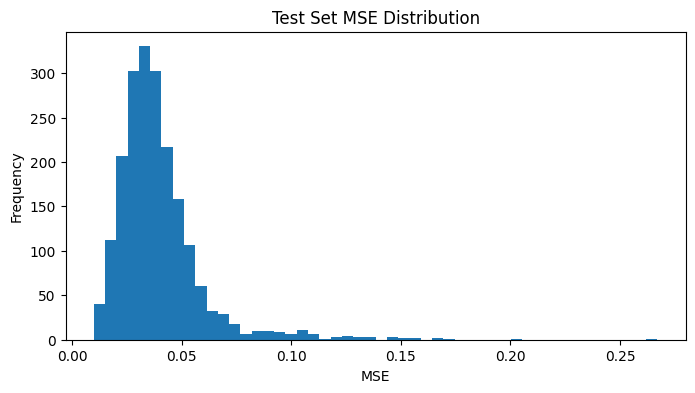

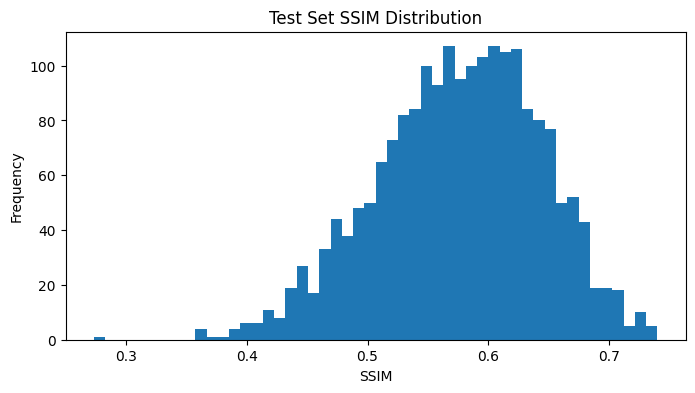

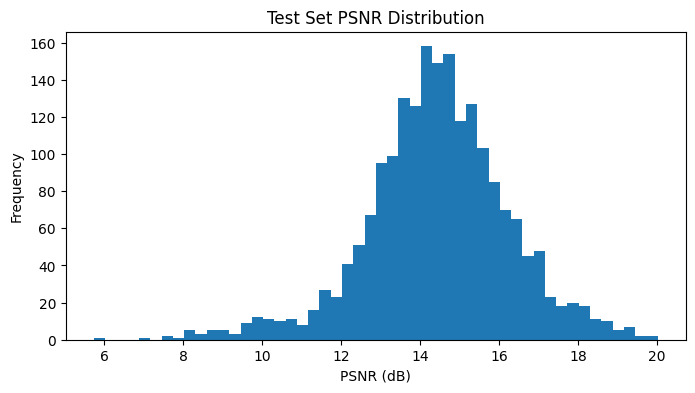

In [ ]:
# ---------------------------------------------
# 8. Plot Histograms of Test Metrics
# ---------------------------------------------
import matplotlib.pyplot as plt

# Load or use the lists directly
# Plot MSE histogram
plt.figure(figsize=(8,4))
plt.hist(all_mse, bins=50)
plt.title('Test Set MSE Distribution')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

# Plot SSIM histogram
plt.figure(figsize=(8,4))
plt.hist(all_ssim, bins=50)
plt.title('Test Set SSIM Distribution')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.show()

# Plot PSNR histogram
plt.figure(figsize=(8,4))
plt.hist(all_psnr, bins=50)
plt.title('Test Set PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# ---------------------------------------------
# 9. Visualize Sample Denoising Results
# ---------------------------------------------
import random
# Select 10 random indices
indices = random.sample(range(len(test_ds)), 10)

# Prepare a figure with 3 columns: Noisy | Denoised | Clean
fig, axes = plt.subplots(10, 3, figsize=(9, 30))
for i, idx in enumerate(indices):
    noisy_img, clean_img = test_ds[idx]
    # Add batch dimension and send through model
    model.eval()
    with torch.no_grad():
        inp = noisy_img.unsqueeze(0).to(device)
        denoised = model(inp).squeeze(0).cpu()
    # Denormalize for display
    def denorm(t): return t * std[0] + mean[0]
    noisy_disp = denorm(noisy_img).squeeze().cpu().numpy()
    denoised_disp = denorm(denoised).squeeze().cpu().numpy()
    clean_disp = denorm(clean_img).squeeze().cpu().numpy()
    # Plot
    axes[i, 0].imshow(noisy_disp, cmap='gray'); axes[i, 0].axis('off');
    axes[i, 0].set_title('Noisy')
    axes[i, 1].imshow(denoised_disp, cmap='gray'); axes[i, 1].axis('off');
    axes[i, 1].set_title('Denoised')
    axes[i, 2].imshow(clean_disp, cmap='gray'); axes[i, 2].axis('off');
    axes[i, 2].set_title('Clean')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.